In [97]:
import pandas as pd
import numpy as np

from catalyst.data_prep.handle_missing_vals import fill_missing_vals
from catalyst.ml.analysis.feat_impt import permutation_importance, plot_feature_importance

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


from lightgbm import LGBMClassifier

import shap

In [106]:
def metric_lgb_auc(model, X_val: pd.DataFrame, y_val: pd.DataFrame) -> float:
    """
    Returns the AUC score based on the model, X_val, and y_val.

    Args:
        model: Fitted machine learning model (e.g., sklearn, xgb, lgb) to be used for prediction
        X_val: Validation data with feature columns.
        y_val: Validation labels.

    Returns:
        AUC score
    """
    pred_proba = model.predict_proba(X_val)
    return roc_auc_score(y_val, pred_proba[:, 1])

In [197]:
train_encoded = pd.read_csv('widsdatathon2020/train_encoded.csv')
val_encoded = pd.read_csv('widsdatathon2020/val_encoded.csv')
train_encoded = train_encoded.reset_index(drop=True)
val_encoded = val_encoded.reset_index(drop=True)

In [198]:
train_encoded.drop(columns=['encounter_id', 'patient_id'], inplace=True)
val_encoded.drop(columns=['encounter_id', 'patient_id'], inplace=True)

In [199]:
X_train = train_encoded.drop(columns=['hospital_death', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob'])
y_train = train_encoded[['hospital_death']]
X_val = val_encoded.drop(columns=['hospital_death', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob'])
y_val = val_encoded[['hospital_death']]

In [200]:
model = LGBMClassifier(class_weight='balanced', objective='binary')
model.fit(X_train[features], y_train)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [201]:
metric_lgb_auc(model, X_val[features], y_val)

0.9119473340521496

In [126]:
val_encoded['hospital_death'].value_counts(normalize=True)

0    0.912719
1    0.087281
Name: hospital_death, dtype: float64

In [124]:
pd.Series(model.predict(X_val)).value_counts(normalize=True)

0    0.79638
1    0.20362
dtype: float64

In [172]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

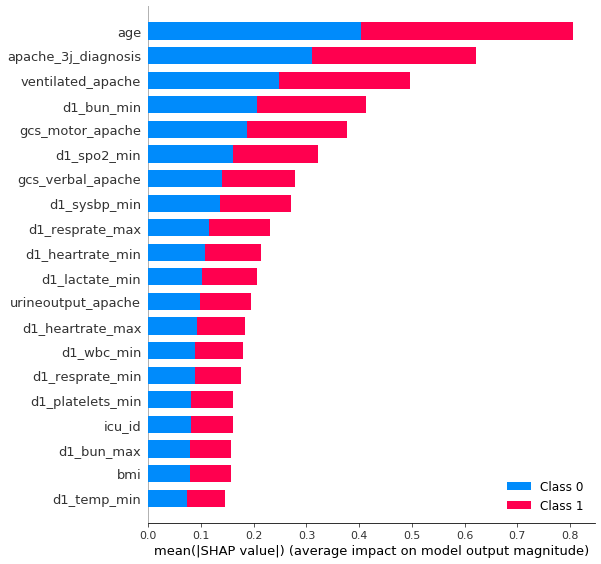

In [173]:
shap.summary_plot(shap_values, X_val, plot_type="bar")

2020-01-15 13:53:30,214 - Baseline metric: 0.902
2020-01-15 13:53:30,981 - Getting permutation importance for icu_id (10/182)
2020-01-15 13:53:31,798 - Getting permutation importance for arf_apache (20/182)
2020-01-15 13:53:32,617 - Getting permutation importance for heart_rate_apache (30/182)
2020-01-15 13:53:33,461 - Getting permutation importance for temp_apache (40/182)
2020-01-15 13:53:34,293 - Getting permutation importance for d1_heartrate_max (50/182)
2020-01-15 13:53:35,134 - Getting permutation importance for d1_spo2_max (60/182)
2020-01-15 13:53:36,007 - Getting permutation importance for h1_diasbp_invasive_max (70/182)
2020-01-15 13:53:36,907 - Getting permutation importance for h1_mbp_max (80/182)
2020-01-15 13:53:37,798 - Getting permutation importance for h1_sysbp_max (90/182)
2020-01-15 13:53:38,715 - Getting permutation importance for d1_bun_max (100/182)
2020-01-15 13:53:39,689 - Getting permutation importance for d1_hemaglobin_max (110/182)
2020-01-15 13:53:40,585 - 

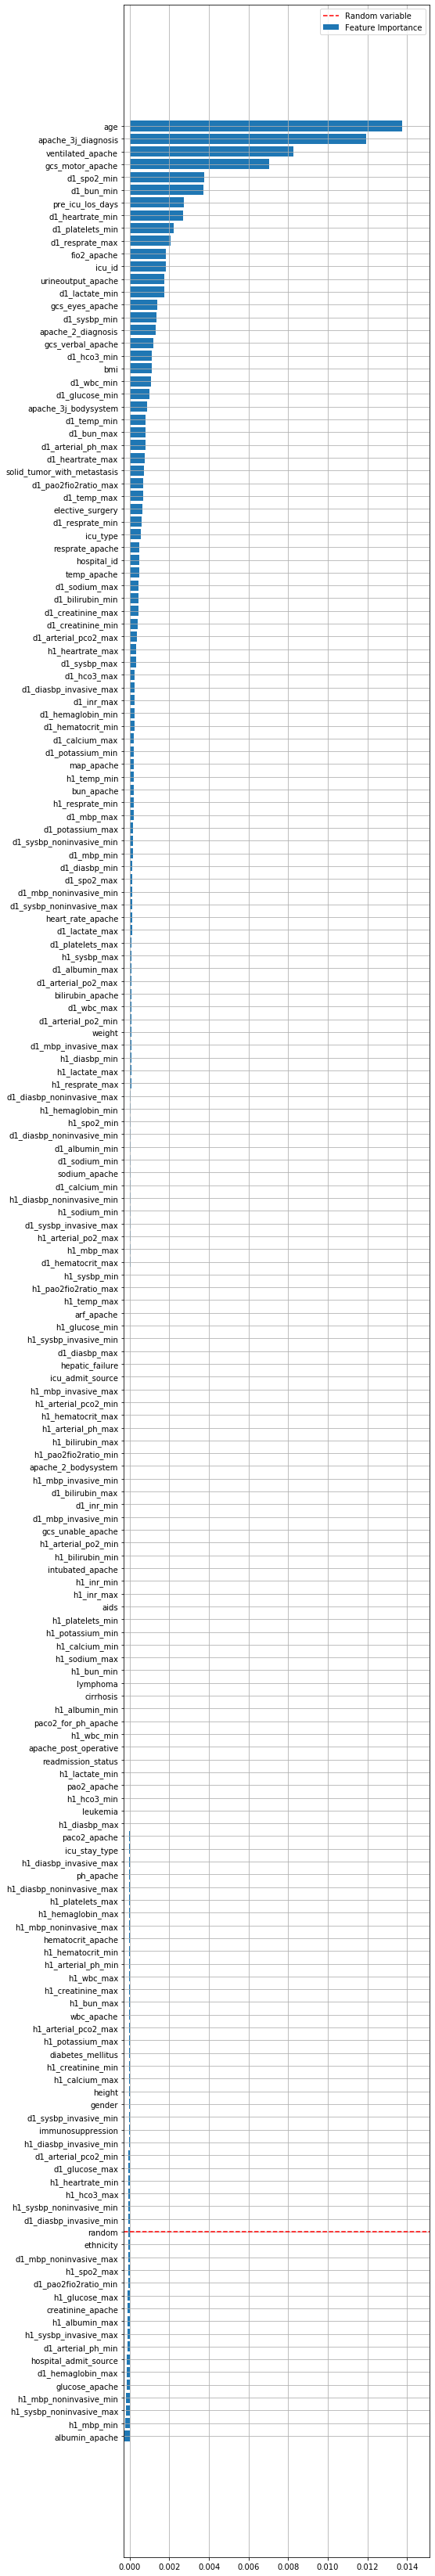

In [174]:
np.random.seed(1368)
X_train['random'] = np.random.random(size=X_train.shape[0])
X_val['random'] = np.random.random(size=X_val.shape[0])

model = LGBMClassifier(class_weight='balanced', objective='binary')
model.fit(X_train, y_train)

feat_impt = permutation_importance(model, X_val, y_val, metric_lgb_auc)
plot_feature_importance(feat_impt)

In [193]:
features = list(feat_impt.head(50).feature)

In [194]:
features

['age',
 'apache_3j_diagnosis',
 'ventilated_apache',
 'gcs_motor_apache',
 'd1_spo2_min',
 'd1_bun_min',
 'pre_icu_los_days',
 'd1_heartrate_min',
 'd1_platelets_min',
 'd1_resprate_max',
 'fio2_apache',
 'icu_id',
 'urineoutput_apache',
 'd1_lactate_min',
 'gcs_eyes_apache',
 'd1_sysbp_min',
 'apache_2_diagnosis',
 'gcs_verbal_apache',
 'd1_hco3_min',
 'bmi',
 'd1_wbc_min',
 'd1_glucose_min',
 'apache_3j_bodysystem',
 'd1_temp_min',
 'd1_bun_max',
 'd1_arterial_ph_max',
 'd1_heartrate_max',
 'solid_tumor_with_metastasis',
 'd1_pao2fio2ratio_max',
 'd1_temp_max',
 'elective_surgery',
 'd1_resprate_min',
 'icu_type',
 'resprate_apache',
 'hospital_id',
 'temp_apache',
 'd1_sodium_max',
 'd1_bilirubin_min',
 'd1_creatinine_max',
 'd1_creatinine_min',
 'd1_arterial_pco2_max',
 'h1_heartrate_max',
 'd1_sysbp_max',
 'd1_hco3_max',
 'd1_diasbp_invasive_max',
 'd1_inr_max',
 'd1_hemaglobin_min',
 'd1_hematocrit_min',
 'd1_calcium_max',
 'd1_potassium_min']

In [76]:
X_train.pre_icu_los_days.median()

0.138194444

In [77]:
from catalyst.ml.model.ligthgbm_model import LGBModel

In [93]:
model = LGBModel('lgbm', 'binary', num_boost_round=100)

In [94]:
model.fit(X_train, y_train)

In [95]:
model.predict(X_val)

array([0, 0, 0, ..., 0, 0, 0])

In [96]:
metric_lgb_auc(model, X_val, y_val)

0.666772521743257

- cross-val?
- param tuning?
- feat engineering?
- ordinal encoding?